<a href="https://colab.research.google.com/github/justinwickelgren/data-science-class/blob/main/Unit_8_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install pymc-bart
!pip install preliz

In [3]:
import pymc_bart as pmb
import preliz as pz

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

I did this

**Task2**:

What is a decision tree? How do they work?

A decision tree is a flowchart-like graph where each node represents a decision and has children nodes for each option. A series of decisions can be modeled by moving from the root node along the edges corresponding to the decisions you wish to make, and the final node will be the outcome.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

Depth is how many "generations" of children the parent node has. If a tree is too deep, it overfits. If it is not deep enough, it will not capture the patterns in the data effectively.

**Task4:**

How are BART models similar and different from a decision tree?

A BART model sums the result of a group of decision trees to get the final prediction. The BART model also limits the depth of the trees, which reduces the risk of overfitting.

**Task5**:

Why would we use a BART model instead of a decision tree?

They are better than a single decision tree because each tree can represent a different pattern in the data, creating better overall predictions. The trees in a BART model are modified based on the other trees, which encourages them to pick up different patterns rather than become identical.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [4]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


Output()

Output()

<Axes: xlabel='y'>

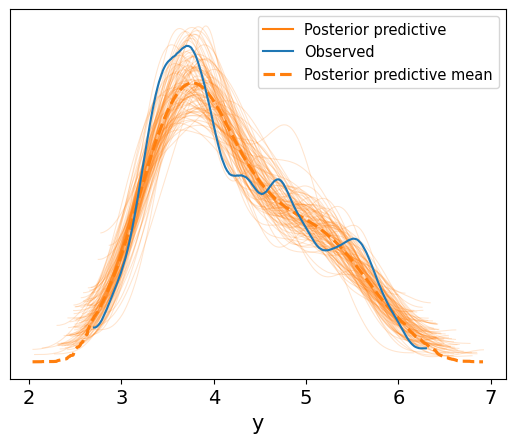

In [7]:
X = penguins[['flipper_length', 'bill_depth', 'bill_length']].to_numpy()
Y = penguins['body_mass'].to_numpy()

with pm.Model() as model:
    s = pm.HalfNormal('s', 1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ", pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata = pm.sample(compute_convergence_checks=False)

pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


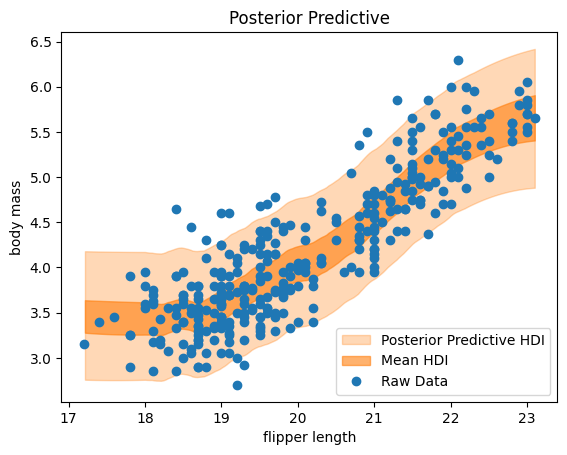

In [10]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T


idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper length",
    ylabel="body mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I do think that it does capture the true association. A positive correlation between body mass and flipper length make sense, because a larger penguin would have more body mass and longer flippers (and the inverse for a smaller penguin). The relatively flat parts at the extreme left and right also make sense because most penguins with the shortest or longest flippers likely have unusually short/long flippers even relative to penguins with similar masses.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

<Axes: ylabel='R²'>

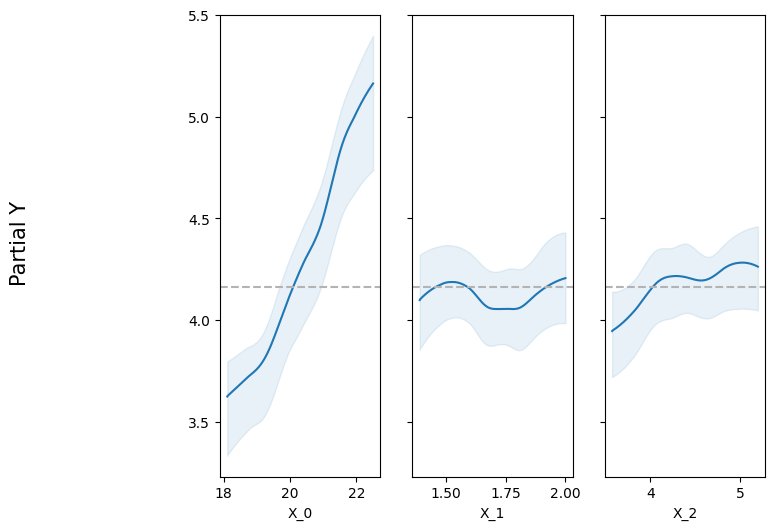

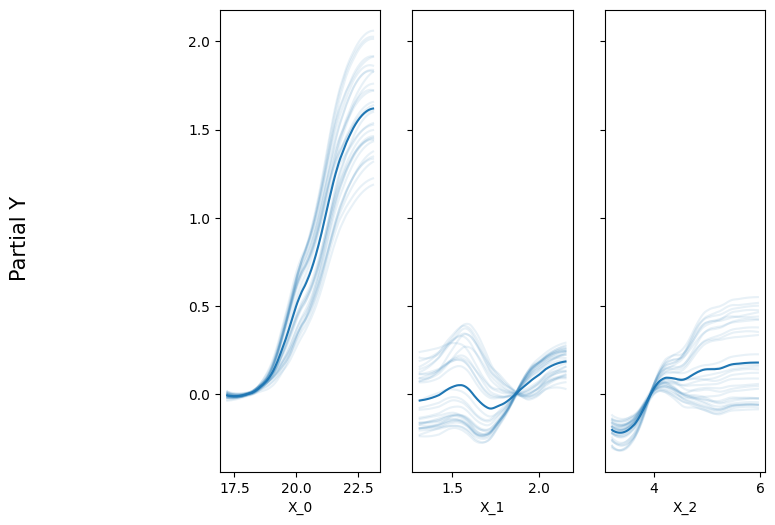

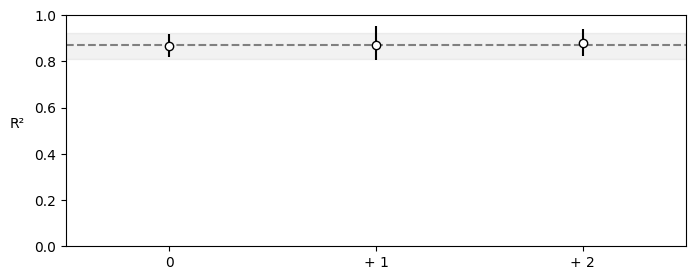

In [11]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))
pmb.plot_ice(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))
vi = pmb.compute_variable_importance(idata, μ_, X)
pmb.plot_variable_importance(vi)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

Flipper length (the left plot) is the most important, but they are all important. In the partial dependence plots, we see a clear and strong correlation between flipper length and body mass. Conversely, bill depth and bill length are roughly flat, meaning they have little correlation with body mass. The individual conditional expectation plot shows the lines fairly close together at lower flipper lengths, so that is a good predictor. However, the lines spread out at higher flipper lengths, so other variables are necessary to predict in that region. The variable importance shows almost identical values for all variables, so we really need all three to predict effectively.